In [1]:
import numpy as np 
import pandas as pd
import scipy.io as sio
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.image import imread
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from scipy.stats import uniform

# Problem 1

The dataset compute_servers.mat contains data that measure the throughput (mb/s) (second column) and latency (ms) (first column) of 307 server computers being monitored. You suspect that most of these examples are "normal" examples of the servers operating normally, but there may also be some examples of servers acting anomalously within this dataset.

a. Make a scatter plot of the data. The first columm is latency and the second is throughput. Does it look like that there are anomalies?

b. Now we will use a Gaussian mixture model to detect anomalous examples. Just by looking at the plot in Part (a), how many Gaussian distributions should be considered in the mixture model?

c. Use the number of Gaussian distributions found in Part (b) to build a Gaussian mixture model for the data. Show the weight(s), mean(s) and covariance matrix (matrices) of the Gaussian distriubtion(s).

d. Now that you have estimated the Gaussian parameters, we can use it for anomaly detection as we did in Lecture 12. Consider a range of percentiles: 100 percentiles equidistantly distributed between 0.001 and 5, i.e., between the 0.001th percentile and 5th percentile of the densities. Use the true labels provided in the data and F1 score to find the best percentile that should be used for anomaly detection.

e. Make a scatter plot of the data. This time, use a different color for the anomalous data points.

In [2]:
os.chdir('/Users/AM/Documents/_CU Masters/2021 spr Python ML_5027/ML_py_code/hw_data')
data = sio.loadmat('compute_servers.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [3]:
print(data['X'].shape)
data['__header__']

(307, 2)


b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 15:37:10 2011'

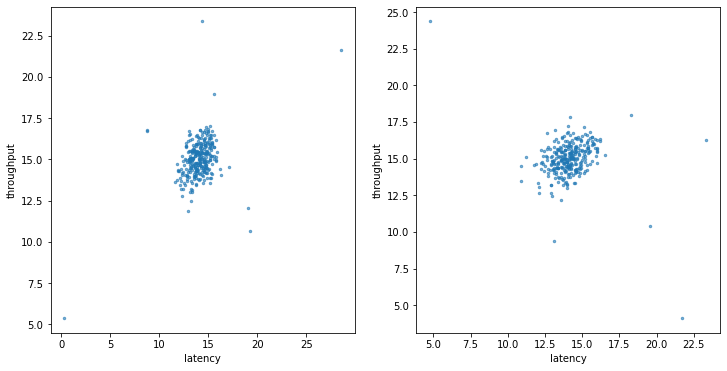

In [4]:
s=6
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(data['Xval'][:,0], data['Xval'][:,1], s = s, alpha=0.6)
plt.xlabel('latency')
plt.ylabel('throughput')
plt.subplot(1,2,2)
plt.scatter(data['X'][:,0], data['X'][:,1], s = s, alpha=0.6)
plt.xlabel('latency')
plt.ylabel('throughput')
plt.show()

**It was not clear which X to use - Xval or X. I chose X (the right plot)**

Some observations look like outliers/ anomalies. 

#1_b

The plot has only one aparent area of concentration - it is reasonale to use one Gaussian distribution

In [5]:
#1_c

model_G = GaussianMixture(n_components = 1, n_init = 30, random_state = 10)
model_G.fit(data['X'], data['yval'])
# Show the weight(s), mean(s) and covariance matrix (matrices) 
#of the Gaussian distriubtion(s).

model_G.weights_

array([1.])

In [6]:
model_G.means_

array([[14.11222578, 14.99771051]])

In [7]:
model_G.covariances_

array([[[ 1.83263241, -0.22712233],
        [-0.22712233,  1.70974633]]])

In [16]:
#1_d
#Consider a range of percentiles: 100 percentiles equidistantly distributed between 0.001 and 5, 
#i.e., between the 0.001th percentile and 5th percentile of the densities. 
#Use the true labels provided in the data and F1 score to find the best percentile 
#that should be used for anomaly detection.
percentiles = np.linspace(start=0.001, stop=5, num=100)
prob = np.exp(model_G.score_samples(data['X'])) 
#prob = model_G.score_samples(data['X'])

F1 = []
for percentile in percentiles:
    threshold = np.percentile(prob, percentile)
    y_pred = prob < threshold
    F1.append(f1_score(data['yval'], y_pred))

i_max_F1 = np.argmax(F1)
i_max_F1

33

In [9]:
percentiles[i_max_F1]

1.6673333333333331

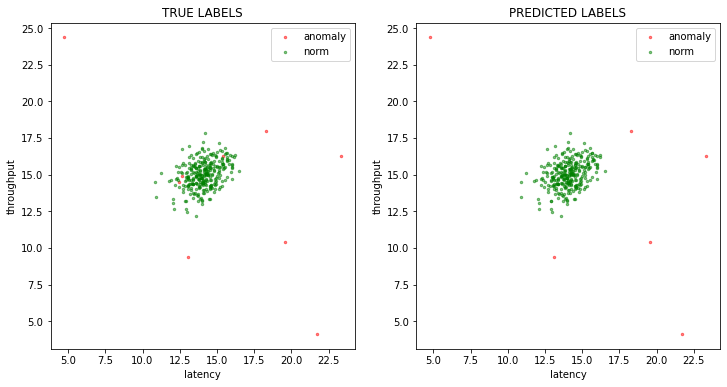

In [10]:
#1_e. Make a scatter plot of the data. 
# This time, use a different color for the anomalous data points.
threshold = np.percentile(prob, percentiles[i_max_F1])
yt = data['yval']
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
anom = (yt == 1).reshape(-1)
norm = (yt == 0).reshape(-1)
plt.scatter(data['X'][anom,0], data['X'][anom,1], s = s, c = 'red', label = "anomaly", alpha=.5)
plt.scatter(data['X'][norm,0], data['X'][norm,1], s = s, c = 'green', label = 'norm', alpha=.5)
plt.legend()
plt.title("TRUE LABELS")
plt.xlabel('latency')
plt.ylabel('throughput')

plt.subplot(1,2,2)
anom = prob < threshold
norm = prob >= threshold
plt.scatter(data['X'][anom,0], data['X'][anom,1], s = s, c = 'red', label = "anomaly", alpha=.5)
plt.scatter(data['X'][norm,0], data['X'][norm,1], s = s, c = 'green', label = 'norm', alpha=.5)
plt.title("PREDICTED LABELS")
plt.legend()
plt.xlabel('latency')
plt.ylabel('throughput')
plt.show()

## Problem 2

In this exercise, you will implement the K-means algorithm for image compression. Recall in a straightforward color representation of an image, each pixel is represented as three usigned integers ranging from 0 to 255 that specify the red, gree and blue intensity values. This encoding is refered to as the RGB encoding. The image included 'bird_small.png' contains thousands of colors, and you will reduce the number of colors to 16 colors.

Use the K-means algorithm to select the 16 colors that will be used to represent the compressed image. Specifically, treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group the pixels in the 3-dimensional RGB space. Once you have computed the cluster centroids on
the image, you will then use the 16 colors to replace the pixels in the original
image.

a) Load the image (128 by 128 by 3) and show the image. Reshape it to a two dimensional array with 3 columns. 

b) Apply K-Means clustering to the image data with 16 clusters and show the centroids. Set the random_state to 10.

c) Now, you have significantly reduced the number of bits (bytes) that are required to describe the image. The original image required 24 bits (or 3 bytes, one for each of R,G,B)  for each one of the $128\times 128$ pixel locations, resulting in total size of $128\times128\times24 = 393216$ bits. The new representation requires some
overhead storage in form of a dictionary of 16 colors, each of which require
$24$ bits, but the image itself then only requires 4 bits (an unsigned integer from 0 to 15 indicating the cluster number) per pixel location. The total number of bits used is therefore $16 \times 24 + 128 \times 128 \times 4 = 65920$ bits,
which corresponds to compressing the original image by about a factor of 6.

Now view the effects of the compression by reconstructing the image based only on the centroid assignments. Specifically, you can replace the RGB intensities at each pixel location with the mean of the centroid assigned to it.

(128, 128, 3)

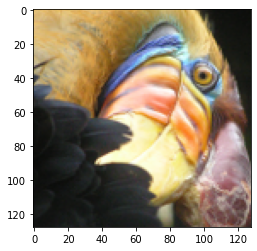

In [11]:
#2_a
os.chdir('/Users/AM/Documents/_CU Masters/2021 spr Python ML_5027/ML_py_code/hw_data')
image = imread("bird_small.png")
plt.imshow(image)
image.shape

In [12]:
#2_b
image_resh = image.reshape(-1,3)
scaler = StandardScaler()
image_resh_sc = scaler.fit_transform(image_resh)
K_means = KMeans(n_clusters=16, random_state=10)
K_means.fit(image_resh_sc)
K_means.cluster_centers_

array([[-4.2593923e-01,  7.6171412e-04,  1.2420616e+00],
       [-1.1509417e+00, -1.0799057e+00, -8.8317007e-01],
       [ 1.3345398e+00,  1.4814600e+00,  1.2913380e+00],
       [ 9.1321933e-01,  7.2634137e-01,  1.7763585e-01],
       [ 1.5542424e-01,  9.2720203e-02,  2.4362807e-01],
       [ 8.7337321e-01,  9.6263146e-01,  1.5346848e+00],
       [-1.3621200e+00, -1.3127543e+00, -1.1621466e+00],
       [-2.4638368e-01, -4.8518401e-01, -7.2938997e-01],
       [ 1.3391802e+00,  1.7242682e+00,  1.9825497e+00],
       [ 1.2307547e-01,  9.3098104e-01,  2.1408019e+00],
       [ 3.2006752e-01,  2.2949050e-03, -6.5431225e-01],
       [ 4.3122587e-01,  5.1295823e-01,  8.1441170e-01],
       [ 1.0779189e+00,  1.0325105e+00,  6.0881418e-01],
       [-8.2927686e-01, -7.9221785e-01, -5.2590656e-01],
       [ 8.4843576e-01,  3.9800373e-01, -3.7754089e-01],
       [-3.6760968e-01, -3.6021698e-01, -3.8467579e-02]], dtype=float32)

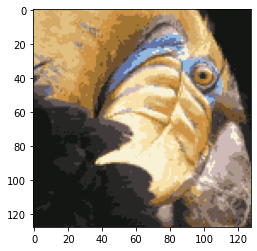

In [13]:
#2_c
image_compressed_resh_sc = K_means.cluster_centers_[K_means.labels_]
image_compressed_resh = scaler.inverse_transform(image_compressed_resh_sc)
image_compressed = image_compressed_resh.reshape(np.shape(image))
plt.imshow(image_compressed)

In [14]:
# without scaling
K_means.fit(image_resh)
K_means.cluster_centers_


array([[0.16169432, 0.1637708 , 0.15570113],
       [0.8695106 , 0.718075  , 0.45645234],
       [0.5879736 , 0.5011669 , 0.44843292],
       [0.45630598, 0.38703945, 0.35551682],
       [0.9771114 , 0.9459172 , 0.8172354 ],
       [0.7588344 , 0.6081482 , 0.3430719 ],
       [0.38695213, 0.4575404 , 0.6472463 ],
       [0.08392304, 0.09092811, 0.08068776],
       [0.2849208 , 0.2569645 , 0.25384617],
       [0.96368873, 0.8592391 , 0.63115495],
       [0.7018231 , 0.63038504, 0.563462  ],
       [0.65124834, 0.47338122, 0.2126474 ],
       [0.91806424, 0.5712558 , 0.25257406],
       [0.56956863, 0.72134906, 0.86848634],
       [0.4634034 , 0.33326584, 0.182744  ],
       [0.8285686 , 0.7470784 , 0.7378628 ]], dtype=float32)